# Correlations of Near-Infrared Spectra to Bulk Properties in Polyolefins, using Principal Component Analysis

In connection with: add DOI INFO/LINK HERE

This code was predominantly produced by Bradley P. Sutliff, with assistance from Tyler B. Martin, and Debra Audus

This notebook is provided in an effort to further open research initiatives and to further the circular economy.

Please direct any questions to Bradley.Sutliff@nist.gov

## Notebook setup

If running in Google Colab, uncomment and run the following command:

In [1]:
# !pip install scikit-fda sklearn-xarray sliced

### Package Imports

In [2]:
# os based imports
import datetime
import gc
import itertools
import os
import pathlib
import re
import string
from itertools import product

# plotting
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.markers as pltmarkers

# data handling
import pandas as pd
import seaborn as sns

# machine learning
import sklearn
import skfda
import xarray as xr
from matplotlib.lines import Line2D
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn_xarray import Target, wrap
from sliced import SlicedInverseRegression

### Define color schemes and plotting dictionaries

In [3]:
# set up notebook for plotting nicely
%matplotlib inline
contxt = "notebook"
sns.set(context=contxt, style="ticks", palette="bright")
pd.options.display.html.use_mathjax = False  # don't render table values as LaTeX

#### Some dictionaries to make plotting names and colors easy

In [4]:
# The colorblind friendly colors that were used in the manuscript
dict_cBlind = {
    "Class1": {"PP": "#0173b2", "PE": "#d55e00"},
    "Class2": {
        "PP": "#0173b2",
        "LDPE": "#ece133",
        "LLDPE": "#ca9161",
        "MDPE": "#de8f05",
        "HDPE": "#d55e00",
        "PP-co-PE": "#56b4e9",
    },
    "fPCA_loading": {2: "#029e73", 3: "#cc78bc", 1: "#949494", 0: "#fbafe4"},
}

# An alternative color choice
dict_colors = {
    "Class1": {"PP": "#cb1b4f", "PE": "#357ba3"},
    "Class2": {
        "PP": "#e13342",
        "LDPE": "#40b7ad",
        "LLDPE": "#348fa7",
        "MDPE": "#37659e",
        "HDPE": "#413d7b",
        "PP-co-PE": "#ad1759",
    },
}
dict_zord = {"PP": 1, "LDPE": 2, "LLDPE": 3,
             "MDPE": 6, "HDPE": 4, "PP-co-PE": 5}

dict_shapes = {
    "Class1": {"PP": "o", "PE": "v"},
    "Class2": {
        "PP": "o",
        "iPP": "h",
        "rPP": "H",
        "LDPE": "<",
        "LLDPE": "^",
        "MDPE": "v",
        "HDPE": ">",
        "PP-co-PE": "H",
    },
}

axis_dict = {
    "Density": "Density [g/cm$^3$]",
    "Crystallinity": "Crystallinity [%]",
    "Mw(IR) (g_per_mol)": "Mw [g/mol]",
    "PDI(IR)": "PDI(IR)",
    "Mw(MALS) g_per_mol": "Mw [g/mol]",
    "PDI(MALS)": "PDI",
    "Mw(Viscometer) g_per_mol": "Mw(Viscometer) [g/mol]",
    "PDI(Visco)": "PDI",
    "MHa": "MHa",
    "MHK dL_per_g": "MHK [dL/g]",
    "SCB_per_1000C (IR)": "$\mathregular{CH_3/1000 C}$",
    "LCBf_per_1000C (MALS)": "Long Chain Branching/1000 C",
    "pc0": "First fPC",
    "pc1": "Second fPC",
    "pc2": "Third fPC",
    "pc3": "Fourth fPC",
}

### Set our color palette to match one of our dictionaries

In [5]:
cpalette = dict_cBlind

### Define functions used in this code

In [6]:
def fix_markers(scatter_plot, marker_vector):
    """
    A function to apply new markers to a scatter_plot
    based on a vector of markers. marker_vector must have
    the same dimension as the x and y for scatter_plot
    """
    marker_locs=[]
    for marker in marker_vector:
        if marker in [i for i in Line2D.markers]:
            obj_marker = pltmarkers.MarkerStyle(marker)
        else:
            print(f'{marker} is not a viable marker')
        marker_loc = obj_marker.get_path(
        ).transformed(obj_marker.get_transform())
        marker_locs.append(marker_loc)
    scatter_plot.set_paths(marker_locs)
    return scatter_plot

In [7]:
# define functions to then make function transformers:
# each of these will read from an Xarray DataArray
# and return another DataArray
def MSC_correct_da(sub_da, wavenumber_dim="Wavenumber", sample_dim="sample"):
    """
    Multiplicative  scatter correction first calculates a mean reference spectrum
    from a set of data. Data is averaged (mean) by the sample_dim. The reference
    spectrum is then used to fit a linear regression between the reference spectrum
    and each of the sample spectra. The coefficients of this fit are then used to
    normalize the data.

    sub_da = an Xarray DataArray containing only the samples to be combined/normalized
            using the same reference spectrum
    wavenumber_dim = the name of the dimension holding relevant wavenumber info
    sample_dim = the name of the dimension that should be reduced in the creation
            of the reference spectrum
    data_dim = the name of the DataArray in the Dataset that you want to normalize.
    """
    sub_da_clean = sub_da.copy()
    sub_da["MCC_mean"] = sub_da.mean(wavenumber_dim)
    sub_da["MCC"] = sub_da - sub_da["MCC_mean"]
    sub_da["ref_spectra"] = sub_da["MCC"].mean(sample_dim)

    polyfit = sub_da.swap_dims(Wavenumber="ref_spectra")["MCC"].polyfit(
        "ref_spectra", 1
    )["polyfit_coefficients"]
    sub_da["MSC"] = (sub_da["MCC"] - polyfit.sel(degree=0)) / \
        (polyfit.sel(degree=1))
    sub_da["m"] = polyfit.sel(degree=1).reset_coords(drop=True)
    sub_da["b"] = polyfit.sel(degree=0).reset_coords(drop=True)
    sub_da_clean["MSC"] = sub_da["MSC"]
    return sub_da_clean


def MSC_correct_all(data):
    """
    applies the MSC correction to an entire Xarray Dataset
    """
    try:
        da2 = data.swap_dims(sample="sample").copy()
        da3 = (da2.groupby("polymer")
               .map(MSC_correct_da)
               .sortby("sample"))
    except:
        da3 = ((data.groupby("polymer")
                .map(MSC_correct_da)
                .sortby("sample")))

    data2 = data.copy()
    data2 = data2.sortby("sample")
    data2.values = da3.MSC.values
    data2 = data2.rename("MSC")
    return data2


def xr_SG(data):
    """
    applies the Savitzky-Golay filter for an Xarray Dataset
    the delta is set to the average difference between
    consecutive wavenumbers for this Dataset
    """
    dlta = data.Wavenumber.diff('Wavenumber').mean().values
    return data.groupby("sample").map(
        savgol_filter, window_length=249, delta=dlta,
        polyorder=2, deriv=0
    )


def xr_SG2(data):
    """
    applies the Savitzky-Golay filter and takes the second derivative
    for an Xarray Dataset
    """
    dlta = data.Wavenumber.diff('Wavenumber').mean().values
    return data.groupby("sample").map(
        savgol_filter, window_length=249, delta=dlta,
        polyorder=2, deriv=2
    )


def id_func(data):
    """
    returns the same data with no changes
    this is mostly for use as a pipeline placeholder
    for when no function is applied (no-dt, no-filter)
    """
    return data


def my_fPCA(data, n_components=4):
    """
    This takes an Xarray DataArray and converts it to an FDataGrid for fPCA,
    runs fPCA, and then returns a DataArray with fPCA loadings
    and the transformed data.
    
    Additionally, if n_components is between 0 and 1, my_fPCA will return
    enough principal components to explain `n_components` worth of variance 
    
    fPCA_loadings: the 'functions' that are used to transform the data. 
                  These will have dimensions of (Wavenumber, n_components, 1)
    fPCs: the values for the transformed data
          These will have the dimensions of (samples, n_components, 1)
    """

    data2 = data.copy()
    fdata = skfda.FDataGrid(data2, grid_points=data2.Wavenumber.values)
    if n_components <=0:
        print('Invalid number of components please provide a positive number')
    if n_components < 1:
        comps = 1
        sum_ratio = 0
        while sum_ratio < n_components:
            fpca = skfda.preprocessing.dim_reduction.feature_extraction.FPCA(
                n_components=comps
            )
            results = fpca.fit(fdata)
            sum_ratio = sum(results.explained_variance_ratio_)
            comps = comps + 1
    else:
        comps = n_components

    fpca = skfda.preprocessing.dim_reduction.feature_extraction.FPCA(
        n_components=comps)
    results = fpca.fit_transform(fdata)
    ds_fpca = xr.Dataset(
        {
            "fPCA_loadings": xr.DataArray(
                data=fpca.components_.data_matrix.squeeze().T,
                dims=["Wavenumber", "fPCA_loading"],
                coords={
                    "Wavenumber": data2.Wavenumber.values,
                    "fPCA_loading": np.arange(comps),
                },
            ),
            "fPCs": xr.DataArray(
                data=results,
                dims=["sample", "fPCA_loading"],
                coords={
                    "sample": data2.sample.values,
                    "fPCA_loading": np.arange(comps),
                },
            ),
            "fPCA_explainedVariance": xr.DataArray(
                data=fpca.explained_variance_ratio_,
                dims=["fPCA_loading"],
                coords={
                    "fPCA_loading": np.arange(comps),
                },
            ),
        }
    )

    return ds_fpca

### Define transformers that will be used in the analysis pipeline

In [8]:
# by making these functions into transformers they can be directly called
# from within a pipeline
msc_transformer = FunctionTransformer(MSC_correct_all, validate=False)
sg_transformer = FunctionTransformer(xr_SG, validate=False)
sg2_transformer = FunctionTransformer(xr_SG2, validate=False)
id_transformer = FunctionTransformer(id_func, validate=False)

In [9]:
# make a dictionary to match these based on strings that are easier to understand
# we can string these together to make a longer pipeline down the road.
# the basic idea is to apply raw OR MSC, then no-filter, SG, OR SG2
transf_dict = {
    "raw": id_transformer,  # for when we don't actually want to apply any transformations
    "MSC": msc_transformer,  # for when we use the MSC step
    "no-filter": id_transformer, # same as raw, but to be used when deciding to apply SG filter or not
    "SG": sg_transformer,  # SG filter
    "SG2": sg2_transformer, # uses SG filter then returns the second derivative of the smoothed data
}

## Data import

### Load data from our files

It is assumed that the data and code are set up in the following directory structure:  
```
nir_corr_po  
├── Data  
│   ├── AdditionalMeasurementData.csv  
│   ├── NIR  
│   │   └── *.csv  
│   ├── README_data.md  
│   └── SampleInformation.csv  
├── README.md  
└── nir-corr-po.ipynb  
```

First we load the file that has our general sample information

In [10]:
sample_info = pd.read_csv('Data/SampleInformation.csv')
sample_info.tail()

,Resin Code/Original Identifier,Source,Sample,Class1,Class2,Physical State,Alternate names,bigSMILES,CAS number,Material Keywords,reference URL
14,LLDPE-2,Hawaii Pacific University Polymers Kit,H0005LLDPE,PE,LLDPE,Pellet,"linear low density polyethylene,LLDPE,polyethy...","{[][$]CC[$],[$]CC({[$][$]C[$][$]}C)[$][]}",9002-88-4,"polyolefins,semicrystalline,copolymer",https://www.hpu.edu/cncs/cmdr/img/polymerkit1....
15,MDPE,Hawaii Pacific University Polymers Kit,H0006MDPE,PE,MDPE,Pellet,"mid density polyethylene,MDPE,polyethylene","{[][$]CC[$],[$]CC([$])[$],[$]CC([$])([$])[$][]}",9002-88-4,"polyolefins,semicrystalline",https://www.hpu.edu/cncs/cmdr/img/polymerkit1....
16,HDPE-1,Hawaii Pacific University Polymers Kit,H0007HDPE,PE,HDPE,Pellet,"high density polyethylene,HDPE,polyethylene,HD...",{[][$]CC[$][]},9002-88-4,"polyolefins,semicrystalline,linear,homopolymer",https://www.hpu.edu/cncs/cmdr/img/polymerkit1....
17,HDPE-2,Hawaii Pacific University Polymers Kit,H0008HDPE,PE,HDPE,Pellet,"high density polyethylene,HDPE,polyethylene,HD...",{[][$]CC[$][]},9002-88-4,"polyolefins,semicrystalline,linear,homopolymer",https://www.hpu.edu/cncs/cmdr/img/polymerkit1....
18,PP,Hawaii Pacific University Polymers Kit,H0009PP,PP,PP,Pellet,"polypropylene,PP",{[][$]CC(C)[$][]},9003-07-0,"polyolefins,semicrystalline,linear,homopolymer",https://www.hpu.edu/cncs/cmdr/img/polymerkit1....


Now we load the file that has our physical measurement information

In [11]:
add_data = pd.read_csv('Data/AdditionalMeasurementData.csv')
add_data.head()

,Sample,Density [g_per_cm3],Density SEM [g_per_cm3],Crystallinity [%],Mw(IR) [g_per_mol],Dispersity (IR),Mw(MALS) [g_per_mol],Dispersity(MALS),Mw(Viscometer) [g_per_mol],Dispersity(Viscometer),MHa,MHK [dL_per_g],SCB_per_1000C (IR),SCB_per_1000C StDev (IR),LCBf_per_1000C (MALS),LCBf_per_1000C StDev (MALS)
0,S0024LDPE,0.916497,0.001254,0.486853,159150,9.645,339950,17.995,514550,23.885,0.41355,0.007253,28.90,1.131371,0.73890,0.283408
1,S0011PP,0.911211,0.003405,0.438083,420500,7.480,246350,6.185,578300,8.170,0.73000,0.000176,331.60,1.272792,0.00045,0.000495
2,S0040HDPE,0.956345,0.001766,0.624898,144400,7.980,134850,8.750,167250,8.210,0.71295,0.000478,7.35,0.777817,0.20250,0.014566
3,H0007HDPE,0.951718,0.001085,0.557357,138000,12.640,134300,11.420,174200,13.435,0.69600,0.000552,8.70,2.404163,0.13400,0.008000
4,H0008HDPE,0.953928,0.002385,0.655347,133700,7.510,111600,8.665,158850,7.985,0.69800,0.000576,6.75,0.353553,0.07885,0.105005


Finally, we can use our file to generate a list of the csvs that hold the spectral data

In [12]:
samples = sample_info.Sample
replicates = [1, 2, 3, 4, 5, 6]
pre_filelist = itertools.product(samples, replicates)
filelist = [
    f"Data/NIR/{'_'.join([fs[0], str(fs[1])])}.csv" for fs in pre_filelist]

Now we can load in each `*.csv` file from our filelist and add it to an Xarray Dataset. When we load it in, we'll also add all of the information from our other 2 files, and we'll add units where necessary.

In [13]:
cols_to_add = ['Density [g_per_cm3]', 'Density SEM [g_per_cm3]',
               'Crystallinity [%]',
               'SCB_per_1000C (IR)', 'SCB_per_1000C StDev (IR)']
ds_list = []
for filepath in filelist:
    sample = filepath.split('/')[-1].split('.')[0]
    polymer = sample.split('_')[0]
    repeat = sample.split('_')[1].split('.')[0]
    s_info = sample_info.loc[sample_info.Sample == polymer, :]
    add_info = add_data.loc[add_data.Sample == polymer, :]

    # use pandas csv reader to read in file
    dataframe = pd.read_csv(filepath,
                            )
    # convert to Xarray Dataset object
    dataset = dataframe.set_index('Wavenumber').to_xarray()

    # add in extra metadata from filename/filepath
    dataset['polymer'] = str(polymer)
    dataset['sample'] = str(sample)
    dataset['state'] = str(s_info['Physical State'].values[0])
    dataset['repeat'] = int(repeat)
    dataset['Class1'] = str(s_info['Class1'].values[0])
    dataset['Class2'] = str(s_info['Class2'].values[0])
    for column in cols_to_add:
        dataset[column.split('[')[0].strip()] = add_info[column].values[0]

    # add units where applicable
    dataset['Wavenumber'].attrs = {'units': '1/cm'}
    dataset['Intensity'].attrs = {'units': '% Reflectance'}
    dataset['Density'].attrs = {'units': 'g/cm^3'}
    dataset['Crystallinity'].attrs = {'units': '%'}

    # define global attributes
    dataset.attrs = {'creation_date': datetime.datetime.now().strftime('%Y%m%d'),
                     'author': 'Bradley Sutliff',
                     'email': 'Bradley.Sutliff@nist.gov',
                     'data_collected_by': 'Shailja Goyal'}
    # aggregate data into a list
    ds_list.append(dataset)

ds = xr.concat(ds_list, dim='sample')
ds = ds.set_coords(['sample', 'polymer', 'state',
                   'Class2', 'Class1', 'repeat'])
ds

<xarray.Dataset>
Dimensions:                   (Wavenumber: 4149, sample: 114)
Coordinates:
  * Wavenumber                (Wavenumber) float64 4e+03 4.002e+03 ... 1.2e+04
    polymer                   (sample) <U10 'N1476LDPE' ... 'H0009PP'
  * sample                    (sample) <U12 'N1476LDPE_1' ... 'H0009PP_6'
    state                     (sample) <U6 'Pellet' 'Pellet' ... 'Pellet'
    repeat                    (sample) int64 1 2 3 4 5 6 1 2 ... 5 6 1 2 3 4 5 6
    Class1                    (sample) <U2 'PE' 'PE' 'PE' ... 'PP' 'PP' 'PP'
    Class2                    (sample) <U8 'LDPE' 'LDPE' 'LDPE' ... 'PP' 'PP'
Data variables:
    Intensity                 (sample, Wavenumber) float64 4.443 4.447 ... 19.11
    Density                   (sample) float64 0.9197 0.9197 ... 0.8873 0.8873
    Density SEM               (sample) float64 0.001673 0.001673 ... 0.004277
    Crystallinity             (sample) float64 0.3126 0.3126 ... 0.4379 0.4379
    SCB_per_1000C (IR)        (sample) float64 21.2 21.2 21.2 ... 312.9 312.9
    SCB_per_1000C StDev (IR)  (sample) float64 1.56 1.56 1.56 ... 0.495 0.495
Attributes:
    creation_date:      20230522
    author:             Bradley Sutliff
    email:              Bradley.Sutliff@nist.gov
    data_collected_by:  Shailja Goyal

## Raw Data

Take a look at the raw data. This will only plot one of each subclass to keep the plot neat.

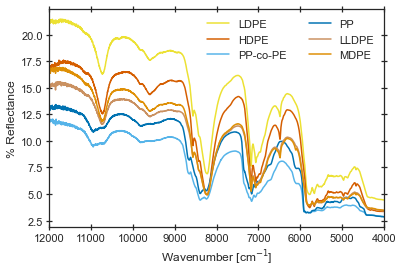

In [14]:
# set info for the plot
color_scheme = "Class2"

fig, ax = plt.subplots()
# loop through for each poylmer subclass
for ptype in pd.unique(ds[color_scheme]):
    # grab data of only our chosen subclass
    ds_sub = ds.where(ds[color_scheme] == ptype, drop=True)
    # grab data for a single replicate, the first replicate
    rep_samp = pd.unique(ds_sub.sample)[0]
    ds_samp = ds_sub.where(ds_sub.sample == rep_samp, drop=True)

    # grab our x and y values
    x = ds_samp.Wavenumber.values.flatten()
    y = ds_samp.Intensity.values.flatten()
    # use one of our predefined dictionaries to choose a color
    # based on the polymer subclass
    color = cpalette[color_scheme][ptype]

    # add the data to our figure
    plt.plot(x, y, c=color, label=ptype)

# clean up the axis
ax.set_ylabel("% Reflectance")
ax.set_xlabel("Wavenumber [cm$^{-1}$]")
ax.set_xlim(12000, 4000)
ax.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    labelbottom=True,
    labeltop=False,
    labelleft=True,
    labelright=False,
    direction="inout",
)
# fix the legend
ax.legend(loc="best", ncol=2, frameon=False)

## Preprocessing Steps

### Multiplicative Scatter Correction (MSC)

MSC is a common NIR scattering correction. It corrects for scattering artifacts, such as those that arise from differences in pellet or powder shape and size.

In [15]:
# make our transformer to apply the MSC correction
trans1 = msc_transformer
# actually apply the correction and transform our data
ds_msc = trans1.fit_transform(ds.Intensity)
# add this data back to the original Dataset
ds = xr.merge([ds, ds_msc])
ds

<xarray.Dataset>
Dimensions:                   (sample: 114, Wavenumber: 4149)
Coordinates:
  * sample                    (sample) <U12 'H0001ULDPE_1' ... 'S0081LDPE_6'
  * Wavenumber                (Wavenumber) float64 4e+03 4.002e+03 ... 1.2e+04
    polymer                   (sample) <U10 'H0001ULDPE' ... 'S0081LDPE'
    state                     (sample) <U6 'Pellet' 'Pellet' ... 'Pellet'
    repeat                    (sample) int64 1 2 3 4 5 6 1 2 ... 5 6 1 2 3 4 5 6
    Class1                    (sample) <U2 'PE' 'PE' 'PE' ... 'PE' 'PE' 'PE'
    Class2                    (sample) <U8 'LDPE' 'LDPE' ... 'LDPE' 'LDPE'
Data variables:
    Intensity                 (sample, Wavenumber) float64 4.076 4.076 ... 12.66
    Density                   (sample) float64 0.9188 0.9188 ... 0.9213 0.9213
    Density SEM               (sample) float64 0.0007945 0.0007945 ... 0.0003695
    Crystallinity             (sample) float64 0.3463 0.3463 ... 0.3708 0.3708
    SCB_per_1000C (IR)        (sample) float64 15.4 15.4 15.4 ... 23.6 23.6 23.6
    SCB_per_1000C StDev (IR)  (sample) float64 1.414 1.414 ... 0.2828 0.2828
    MSC                       (sample, Wavenumber) float64 -4.927 ... 4.686
Attributes:
    creation_date:      20230522
    author:             Bradley Sutliff
    email:              Bradley.Sutliff@nist.gov
    data_collected_by:  Shailja Goyal

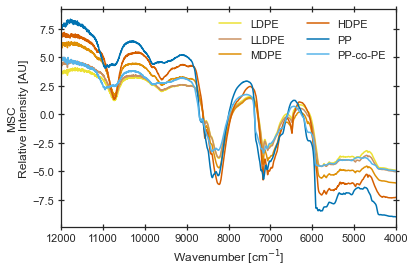

In [16]:
# set info for the plot
color_scheme = "Class2"

fig, ax = plt.subplots()
# loop through for each poylmer subclass
for ptype in pd.unique(ds[color_scheme]):
    # grab data of only our chosen subclass
    ds_sub = ds.where(ds[color_scheme] == ptype, drop=True)
    # grab data for a single replicate, the first replicate
    rep_samp = pd.unique(ds_sub.sample)[0]
    ds_samp = ds_sub.where(ds_sub.sample == rep_samp, drop=True)

    # grab our x and y values
    x = ds_samp.Wavenumber.values.flatten()
    y = ds_samp.MSC.values.flatten()
    # use one of our predefined dictionaries to choose a color
    # based on the polymer subclass
    color = cpalette[color_scheme][ptype]

    # add the data to our figure
    plt.plot(x, y, c=color, label=ptype)

# clean up the axis
ax.set_ylabel("MSC\nRelative Intensity [AU]")
ax.set_xlabel("Wavenumber [cm$^{-1}$]")
ax.set_xlim(12000, 4000)
ax.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    labelbottom=True,
    labeltop=False,
    labelleft=True,
    labelright=False,
    direction="inout",
)
# fix the legend
ax.legend(loc="best", ncol=2, frameon=False)

### Sovitzky-Golay Filtering and Differentiation (SG and SG'')

SG filtering is a common signal smoothing filter. We use it here to clean up some noise, enabling better differentiation. This is also common in the NIR signal processing/chemometric community.

In [17]:
# make another transformer to apply the Sovitzky-Golay Smoothing w/ 2nd deriv.
trans2 = sg2_transformer

# actually apply the correction and transform our data
ds_sg2 = trans2.fit_transform(ds.MSC)
ds_sg2.name = "SG2"
# add this data back to the original Dataset
ds = xr.merge([ds, ds_sg2])
ds

<xarray.Dataset>
Dimensions:                   (sample: 114, Wavenumber: 4149)
Coordinates:
  * sample                    (sample) <U12 'H0001ULDPE_1' ... 'S0081LDPE_6'
  * Wavenumber                (Wavenumber) float64 4e+03 4.002e+03 ... 1.2e+04
    polymer                   (sample) <U10 'H0001ULDPE' ... 'S0081LDPE'
    state                     (sample) <U6 'Pellet' 'Pellet' ... 'Pellet'
    repeat                    (sample) int64 1 2 3 4 5 6 1 2 ... 5 6 1 2 3 4 5 6
    Class1                    (sample) <U2 'PE' 'PE' 'PE' ... 'PE' 'PE' 'PE'
    Class2                    (sample) <U8 'LDPE' 'LDPE' ... 'LDPE' 'LDPE'
Data variables:
    Intensity                 (sample, Wavenumber) float64 4.076 4.076 ... 12.66
    Density                   (sample) float64 0.9188 0.9188 ... 0.9213 0.9213
    Density SEM               (sample) float64 0.0007945 0.0007945 ... 0.0003695
    Crystallinity             (sample) float64 0.3463 0.3463 ... 0.3708 0.3708
    SCB_per_1000C (IR)        (sample) float64 15.4 15.4 15.4 ... 23.6 23.6 23.6
    SCB_per_1000C StDev (IR)  (sample) float64 1.414 1.414 ... 0.2828 0.2828
    MSC                       (sample, Wavenumber) float64 -4.927 ... 4.686
    SG2                       (sample, Wavenumber) float64 4.448e-06 ... -1.0...
Attributes:
    creation_date:      20230522
    author:             Bradley Sutliff
    email:              Bradley.Sutliff@nist.gov
    data_collected_by:  Shailja Goyal

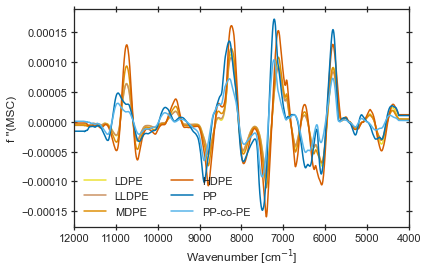

In [18]:
# set info for the plot
color_scheme = "Class2"

fig, ax = plt.subplots()
# loop through for each poylmer subclass
for ptype in pd.unique(ds[color_scheme]):
    # grab data of only our chosen subclass
    ds_sub = ds.where(ds[color_scheme] == ptype, drop=True)
    # grab data for a single replicate, the first replicate
    rep_samp = pd.unique(ds_sub.sample)[0]
    ds_samp = ds_sub.where(ds_sub.sample == rep_samp, drop=True)

    # grab our x and y values
    x = ds_samp.Wavenumber.values.flatten()
    y = ds_samp.SG2.values.flatten()
    # use one of our predefined dictionaries to choose a color
    # based on the polymer subclass
    color = cpalette[color_scheme][ptype]

    # add the data to our figure
    plt.plot(x, y, c=color, label=ptype)

# clean up the axis
ax.set_ylabel("f ''(MSC)")
ax.set_xlabel("Wavenumber [cm$^{-1}$]")
ax.set_xlim(12000, 4000)
ax.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    labelbottom=True,
    labeltop=False,
    labelleft=True,
    labelright=False,
    direction="inout",
)
# fix the legend
ax.legend(loc="best", ncol=2, frameon=False)

## Functional Principal Component Analysis (fPCA)

fPCA reduces the spectra to a set of basis functions (loadings) that describe the variance between all the samples given to the function. Each sample can then be modeled with a series of these basis functions and their corresponding coefficients or scores. The net effect is that large sets of data can be reduced to a few scores (fPCs), enabling easier visualization and faster computing.

In [19]:
# Scale the data so a given wavenumber/feature doesn't control the PCA
sscaler = wrap(StandardScaler(), sample_dim="sample")
ds_scaled = sscaler.fit_transform(ds.MSC)

# another transformer for fPCA
fPCA_transformer = FunctionTransformer(
    my_fPCA, validate=False, kw_args={"n_components": 4}
)

# actually apply the correction and transform our data
ds_fPCA = fPCA_transformer.fit_transform(ds_scaled)
# add this data back to the original Dataset
ds = xr.merge([ds, ds_fPCA])

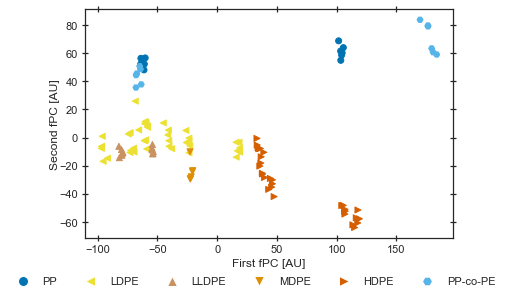

In [20]:
# set info for the plot
color_scheme = "Class2"

fig, ax = plt.subplots(1, 1)

x = ds.fPCs.where(ds.fPCA_loading == 0, drop=True).values.flatten()
y = ds.fPCs.where(ds.fPCA_loading == 1, drop=True).values.flatten()

col_vec = pd.Series(ds[color_scheme].values).map(cpalette[color_scheme])
shape_vec = pd.Series(ds[color_scheme].values).map(dict_shapes[color_scheme])
order = np.argsort(ds[color_scheme].values)

# add the data
# note: fix_markers is a custom function
myscatter=ax.scatter(x[order], y[order],
                    color=col_vec.values[order])
fix_markers(myscatter, shape_vec.values[order])

# adjust axis
ax.set_xlabel(f'{axis_dict["pc0"]} [AU]')
ax.set_ylabel(f'{axis_dict["pc1"]} [AU]', labelpad=-1)
ax.tick_params(
    bottom=True,
    top=True,
    left=True,
    right=True,
    labelbottom=True,
    labeltop=False,
    labelleft=True,
    labelright=False,
    direction="inout",
)

# fix the legend
leg_elems = [
    Line2D(
        [0],
        [0],
        marker=dict_shapes[color_scheme][key],
        color="w",
        markerfacecolor=cpalette[color_scheme][key],
        label=key,
        markersize=10,
    )
    for key in cpalette[color_scheme].keys()
]
fig.legend(
    handles=leg_elems,
    loc="center",
    bbox_to_anchor=[0.5, 0],
    ncol=len(leg_elems),
    frameon=False,
)

plt.tight_layout()

## Linear Regression and Pearson's Correlation

Now that we have reduced the data, we are going to evaluate the correlations between each of our fPCs and the physical correlations we have measured. We will save Pearson's correlation coefficient and the goodness of fit for each pair.

In [21]:
df_LinReg = pd.DataFrame(columns=["Pair", "$r_{corr}$", "$r^2$"])

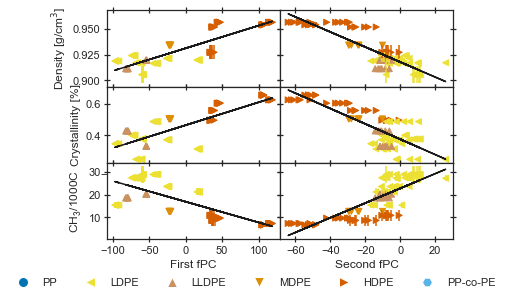

In [22]:
# set up information for the data groupings to loop through
# using the first 2 principal components
pc_list = [0, 1]
# checking correlation with the following
corr_list = ["Density", "Crystallinity", "SCB_per_1000C (IR)"]
# grab standard error/standard deviation where appropriate
err_list = [
    (None, "Density SEM"),
    (None, "Density SEM"),
    (None, None),
    (None, None),
    (None, "SCB_per_1000C StDev (IR)"),
    (None, "SCB_per_1000C StDev (IR)"),
]
# making a list of all combinations of fPCs and physical measurements to evaluate
plot_list = list(itertools.product(corr_list, pc_list))

# note: this is set up to test correlations with either PE or PP
ds_sub = ds.where(ds["Class1"] == "PE", drop=True)

fig, axes = plt.subplots(
    len(corr_list),
    len(pc_list),
    sharey="row",
    sharex="col",
    gridspec_kw={"wspace": 0, "hspace": 0},
)
# loop through our property, fPC pairs
for i, pair in enumerate(plot_list):
    # split up the pairs so we can use them as indices
    pc = pair[1]
    corr = pair[0]
    # grab the SEM/StDev data if available
    corr_yerr = err_list[i][1]
    # make sure plots go on the axis we expect
    ax = axes.flatten()[i]
    # set x and y and y_err
    y = ds_sub[corr].values.flatten()
    x = ds_sub.fPCs[:, pc].values.flatten()
    if corr_yerr:
        yerr = ds_sub[corr_yerr].values.flatten()
    else:
        yerr = None
    # set the colors and shapes of the scatter points
    col_vec = pd.Series(ds_sub[color_scheme].values).map(
        cpalette[color_scheme])
    shape_vec = pd.Series(ds_sub[color_scheme].values).map(
        dict_shapes[color_scheme])

    # make our linear regression model for this pair
    X = x.reshape(-1, 1)
    Y = y.reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    Y_pred = reg.predict(X)
    # Pearson's Correlation
    r_corr, _ = pearsonr(x, y)
    # r^2
    r2 = reg.score(X, Y)
    # save these results in a data frame
    data = pd.DataFrame(columns=["Pair", "$r_{corr}$", "$r^2$"])
    data["Pair"] = [pair]
    data["$r_{corr}$"] = r_corr
    data["$r^2$"] = r2
    df_LinReg = pd.concat([df_LinReg, data])

    # add the data
    # we have to manipulate the plotting order so fewer points get covered up
    order = np.argsort(ds_sub[color_scheme].values)

    # plot the data
    myscatter=ax.scatter(x[order], y[order],
                    color=col_vec.values[order])
    fix_markers(myscatter, shape_vec.values[order])
    #add error bars
    if yerr is not None:
        ax.errorbar(
            x[order],
            y[order],
            yerr=yerr[order],
            fmt="none",
            ecolor=col_vec.values[order],
        )
    # add the linear regression line
    ax.plot(x, Y_pred, color="k")

    # adjust the axes for all of the plots
    ax.tick_params(
        bottom=True,
        top=True,
        left=True,
        right=True,
        labelbottom=False,
        labeltop=False,
        labelleft=False,
        labelright=False,
        direction="inout",
    )

# fixing axis for left and bottom plots
axes.flatten()[0].tick_params(labelleft=True)
axes.flatten()[2].tick_params(labelleft=True, labelbottom=True)
axes.flatten()[4].tick_params(
    labelbottom=True,
    labelleft=True,
)
axes.flatten()[5].tick_params(labelbottom=True)
axes.flatten()[0].set_ylabel(axis_dict[plot_list[0][0]])
axes.flatten()[2].set_ylabel(axis_dict[plot_list[2][0]])
axes.flatten()[4].set_ylabel(axis_dict[plot_list[4][0]])
axes.flatten()[4].set_xlabel(axis_dict[f"pc{plot_list[0][1]}"])
axes.flatten()[5].set_xlabel(axis_dict[f"pc{plot_list[3][1]}"])

# custom legend
leg_elems = [
    Line2D(
        [0],
        [0],
        marker=dict_shapes[color_scheme][key],
        color="w",
        markerfacecolor=cpalette[color_scheme][key],
        label=key,
        markersize=10,
    )
    for key in cpalette[color_scheme].keys()
]
fig.legend(
    handles=leg_elems,
    loc="center",
    bbox_to_anchor=[0.5, 0],
    ncol=len(leg_elems),
    frameon=False,
)


plt.tight_layout()

In [23]:
# ds_sub[corr].values.flatten()
print(corr)
ds_sub

SCB_per_1000C (IR)


<xarray.Dataset>
Dimensions:                   (sample: 90, Wavenumber: 4149, fPCA_loading: 4)
Coordinates:
  * sample                    (sample) <U12 'H0001ULDPE_1' ... 'S0081LDPE_6'
  * Wavenumber                (Wavenumber) float64 4e+03 4.002e+03 ... 1.2e+04
    polymer                   (sample) <U10 'H0001ULDPE' ... 'S0081LDPE'
    state                     (sample) <U6 'Pellet' 'Pellet' ... 'Pellet'
    repeat                    (sample) int64 1 2 3 4 5 6 1 2 ... 5 6 1 2 3 4 5 6
    Class1                    (sample) <U2 'PE' 'PE' 'PE' ... 'PE' 'PE' 'PE'
    Class2                    (sample) <U8 'LDPE' 'LDPE' ... 'LDPE' 'LDPE'
  * fPCA_loading              (fPCA_loading) int64 0 1 2 3
Data variables:
    Intensity                 (sample, Wavenumber) float64 4.076 4.076 ... 12.66
    Density                   (sample) float64 0.9188 0.9188 ... 0.9213 0.9213
    Density SEM               (sample) float64 0.0007945 0.0007945 ... 0.0003695
    Crystallinity             (sample) float64 0.3463 0.3463 ... 0.3708 0.3708
    SCB_per_1000C (IR)        (sample) float64 15.4 15.4 15.4 ... 23.6 23.6 23.6
    SCB_per_1000C StDev (IR)  (sample) float64 1.414 1.414 ... 0.2828 0.2828
    MSC                       (sample, Wavenumber) float64 -4.927 ... 4.686
    SG2                       (sample, Wavenumber) float64 4.448e-06 ... -1.0...
    fPCA_loadings             (Wavenumber, fPCA_loading, sample) float64 -0.0...
    fPCs                      (sample, fPCA_loading) float64 -96.24 ... -2.422
    fPCA_explainedVariance    (fPCA_loading, sample) float64 0.7531 ... 0.0105
Attributes:
    creation_date:      20230522
    author:             Bradley Sutliff
    email:              Bradley.Sutliff@nist.gov
    data_collected_by:  Shailja Goyal

In [24]:
df_LinReg

,Pair,$r_{corr}$,$r^2$
0,"(Density, 0)",0.847096,0.717572
0,"(Density, 1)",-0.856166,0.73302
0,"(Crystallinity, 0)",0.783357,0.613648
0,"(Crystallinity, 1)",-0.800321,0.640514
0,"(SCB_per_1000C (IR), 0)",-0.741796,0.550261
0,"(SCB_per_1000C (IR), 1)",0.800924,0.641479


We have a lot of correlation between variables, but not great goodness of fit, and lot of cross-correlation. To take advantage of the correlations, and get around the cross correlation, we will turn to another technique to plot our physical measurements as a function of the first few fPCs.

## Sliced Inverse Regression (SIR)

Similar to fPCA, SIR can take large sets of data and reduce them to fewer dimensions by using coefficients to weight the data. However, a key difference is that we get to tune SIR with the outputs we want the inputs to predict. This way we can provide the first few fPCs to the SIR, along with the corresponding physical measurement (e.g. density) so that SIR can apply weights to the fPCs($\hat\beta_{SIR}$). $\hat\beta_{SIR}$ will then provide different weighting to the fPCs for each physical measurement, enabling a linear combination of the weighted fPCs ($X\hat\beta_{SIR}$) to predict the physical measurement.

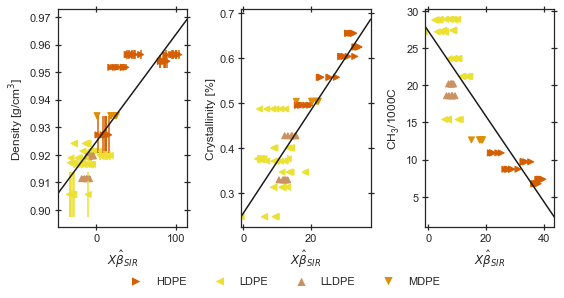

In [25]:
# using the first 3 principal components for SIR
fpcs = 3
# make a DataFrame to record our correlation and fit results
df_SIR = pd.DataFrame()

# setting up the loop information
# checking correlation with the following
plot_list = ["Density", "Crystallinity", "SCB_per_1000C (IR)"]
# grab standard error/standard deviation where appropriate
err_list = [
    (None, "Density SEM"),
    (None, "Density SEM"),
    (None, None),
    (None, None),
    (None, "SCB_per_1000C StDev (IR)"),
    (None, "SCB_per_1000C StDev (IR)"),
]

# note: this is set up to test correlations with either PE or PP
ds_sub = ds.where(ds["Class1"] == "PE", drop=True)
sir_coeffs = np.zeros((len(plot_list), fpcs))

fig, axes = plt.subplots(int(len(plot_list)/len(corr_list)), len(corr_list),
                         figsize=(8, 4))
# loop through our property, fPC pairs
for i, corr in enumerate(plot_list):
    # grab the SEM/StDev data if available
    corr_yerr = err_list[i][1]
    # make sure plots go on the axis we expect
    ax = axes.flatten()[i]
    # set x and y and y_err
    y = ds_sub[corr].values.flatten()
    x = ds_sub.fPCs[:, 0:fpcs].values.reshape(len(y), fpcs)
    if corr_yerr:
        yerr = ds_sub[corr_yerr].values.flatten()
    else:
        yerr = None
    # set the colors and shapes of the scatter points
    col_vec = pd.Series(ds_sub[color_scheme].values).map(
        cpalette[color_scheme])
    shape_vec = pd.Series(ds_sub[color_scheme].values).map(
        dict_shapes[color_scheme])

    # here is the actual SIR stuff
    sir = SlicedInverseRegression(n_directions=1)
    sir.fit(x, y)
    coeffs = sir.directions_
    x_new = sir.transform(x).T.reshape(-1, 1)

    # add in a predicted fit
    reg = LinearRegression().fit(x_new, y)
    x_model = np.linspace(x_new.min() * 0.9, x_new.max()
                          * 1.1, 50).reshape(-1, 1)
    y_model = reg.predict(x_model)
    score = reg.score(x_new, y)
    # save it to dataframe for model comparisons
    r_corr, _ = pearsonr(x_new[:, 0], y)
    r2 = reg.score(x_new, y)
    df_smallSIR = pd.DataFrame(
        {"polymer": ["PE"], "Property": [corr],
            "$r_{corr}$": r_corr, "$r^2$": [r2]}
    )
    df_SIR = pd.concat([df_SIR, df_smallSIR], ignore_index=True)
    sir_coeffs[i] = sir.directions_

    # add the data
    # we have to manipulate the plotting order so fewer ponts get covered up
    order = np.argsort(ds_sub[color_scheme].values)

    # plot the data
    myscatter=ax.scatter(x_new[order], y[order],
                    color=col_vec.values[order])
    fix_markers(myscatter, shape_vec.values[order])
    # add error bars
    if yerr is not None:
        ax.errorbar(
            x_new[order],
            y[order],
            yerr=yerr[order],
            fmt="none",
            ecolor=col_vec.values[order],
        )
    # show the SIR model
    ax.plot(x_model, y_model, "k")

    # adjust the axes for all of the plots
    ax.tick_params(
        bottom=True,
        top=True,
        left=True,
        right=True,
        labelbottom=True,
        labeltop=False,
        labelleft=True,
        labelright=False,
        direction="inout",
    )
    ax.set_ylabel(axis_dict[corr])
    ax.set_xlabel(r"$X\hat\beta_{SIR}$")
    ax.set_xlim(x_model.min(), x_model.max())


# custom legend
leg_elems = [
    Line2D(
        [0],
        [0],
        marker=dict_shapes[color_scheme][key],
        color="w",
        markerfacecolor=cpalette[color_scheme][key],
        label=key,
        markersize=10,
    )
    for key in ['HDPE', 'LDPE', 'LLDPE', 'MDPE']
]
fig.legend(
    handles=leg_elems,
    loc="center",
    bbox_to_anchor=[0.5, 0],
    ncol=len(leg_elems),
    frameon=False,
)


plt.tight_layout()

In [26]:
df_SIR

,polymer,Property,$r_{corr}$,$r^2$
0,PE,Density,0.887727,0.788059
1,PE,Crystallinity,0.866393,0.750637
2,PE,SCB_per_1000C (IR),-0.879952,0.774316


## Feature Importance Ranking Measure

To determine the relative contributions of the fPCs to the properties, we can make use of the sliced inverse regression coefficients. One challenge is that the fPCs are correlated and thus the common technique (denoted Isimp here) is incorrect. To fix this, we use the Feature Importance Ranking Measure as discussed in [Zien, Alexander, Nicole Krämer, Sören Sonnenburg, and Gunnar Rätsch. “The feature importance ranking measure.” *arXiv preprint arXiv:0906.4258* (2009)](https://arxiv.org/abs/0906.4258). Isimp is computed via equation 3 therein, while FIRM is calculated via $\mathbf{Q} = \mathbf{D}^{-1} \mathbf{\Sigma} \mathbf{w}$ as described in the text after equation 12.

In [27]:
ds_pe = ds.where(ds.Class1 == 'PE', drop=True)

pc0 = ds_pe.fPCs.where(ds_pe.fPCA_loading == 0,
                       drop=True).values.flatten()
pc1 = ds_pe.fPCs.where(ds_pe.fPCA_loading == 1,
                       drop=True).values.flatten()
pc2 = ds_pe.fPCs.where(ds_pe.fPCA_loading == 2,
                       drop=True).values.flatten()

pcvals = np.array([pc0, pc1, pc2])
pcvar = np.var(pcvals, axis=1)


Sigma = np.cov(pcvals, ddof=0)

D = np.diagonal(Sigma)
D = np.sqrt(D)
Dinv = np.diag(1/D)


# The following line assumes that pcs are uncorrelated. Use this *only* for Isimp
SigmaSimp = np.diag(np.diagonal(Sigma))

for i, pair in enumerate(plot_list):
    print()
    print(pair)

    Isimp = np.dot(SigmaSimp, sir_coeffs[i])
    Isimp = np.abs(np.dot(Dinv, Isimp))
    Isimp = Isimp/np.sum(Isimp)
    print("Isimp", Isimp)

    Ifirm = np.dot(Sigma, sir_coeffs[i])
    Ifirm = np.abs(np.dot(Dinv, Ifirm))
    Ifirm = Ifirm/np.sum(Ifirm)
    print("Ifirm", Ifirm)


Density
Isimp [0.48310662 0.43716478 0.0797286 ]
Ifirm [0.40600964 0.42319686 0.1707935 ]

Crystallinity
Isimp [0.22327124 0.56580185 0.21092691]
Ifirm [0.36881638 0.43890243 0.19228119]

SCB_per_1000C (IR)
Isimp [0.10765276 0.61229239 0.28005485]
Ifirm [0.45901945 0.44594743 0.09503312]
